# NLP Project 
Perform topic modeling on YouTube transcripts using unsupervised learning to extract meaningful topics and use them for improved indexing in a RAG system or summarization.

In [15]:
# imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re 
import pyarabic.araby as araby
from nltk.corpus import stopwords
import nltk
from typing import List
from tqdm.notebook import tqdm
import arabic_reshaper 
from bidi.algorithm import get_display
import json 
import seaborn as sns


### 1. Data Loading

In [2]:
# Folders
DATA_FOLDERS = ["Al_Mokhbir_Al_Eqtisadi/raw_data", 'Da7ee7/raw_data', 'Fi_Al_Hadaraa/raw_data']
META_DATA = ["Al_Mokhbir_Al_Eqtisadi/meta_data", 'Da7ee7/meta_data', 'Fi_Al_Hadaraa/meta_data']

In [3]:
# Create a code that renames the files in the Da7ee7/meta_data folder to remove the _annotation part of the file name
def rename_files():
    for i in range(len(META_DATA)):
        for filename in os.listdir(META_DATA[i]):
            if filename.endswith(".json"):
                new_filename = filename.replace("_annotation", "")
                os.rename(META_DATA[i] + '/' + filename, META_DATA[i] + '/' + new_filename)
    return "Files renamed successfully"

rename_files()

'Files renamed successfully'

In [4]:
# Read data from folder
def read_data_from_folder(folders: List[str]) -> pd.DataFrame:
    """
    Read data from a folder

    Args:
    folders: List of folders to read data from

    Returns:
    DataFrame: A DataFrame with columns 'episode_transcript' and 'creator
    """
    data = []
    for folder in folders:
        for file in os.listdir(folder):
            creator_name = folder.split("/")[0]
            if file.endswith(".txt"):
                file_data = {'episode_transcript': "", 'creator': creator_name}
                
                # Read text content
                with open(os.path.join(folder, file), 'r') as f:
                    file_data['episode_transcript'] = f.read()
                
                # Get the length using the same filename of the txt but json
                try:
                    with open(os.path.join(folder.replace("raw_data", "meta_data"), file.replace(".txt", ".json")), 'r') as f:
                        metadata = json.load(f)
                        file_data['length'] = metadata.get('length', None)
                except FileNotFoundError:
                    file_data['length'] = None


                # Get the tags array using the same filename of the txt but json
                try:
                    with open(os.path.join(folder.replace("raw_data", "meta_data"), file.replace(".txt", ".json")), 'r') as f:
                        metadata = json.load(f)
                        file_data['tags'] = metadata.get('tags', None)
                except FileNotFoundError:
                    file_data['tags'] = None
                
                # Append to data list
                data.append(file_data)
    
    return pd.DataFrame(data)

df = read_data_from_folder(DATA_FOLDERS)
print(df.shape)
df.sample(10)

(426, 4)


,episode_transcript,creator,length,tags
164,بعد اقل من شهرين على انطلاق العدوان\nالاسرائيل...,Al_Mokhbir_Al_Eqtisadi,00:19:10,None
110,من حوالي 21 سنة\nوتحديداً في يناير 2001\nالرئي...,Al_Mokhbir_Al_Eqtisadi,00:20:35,None
413,وقبل ما نبدأ عرضنا،\nأحب أرحّب بصاحب فكرة العر...,Fi_Al_Hadaraa,00:20:14,None
418,1 منّه، 2 منّه، 3 منّه، 4 منّه،\n5 منّه، 6 منّ...,Fi_Al_Hadaraa,00:18:02,None
37,في الساعات الاولى من صباح يوم الاثنين 17\nيولي...,Al_Mokhbir_Al_Eqtisadi,00:17:01,None
171,في 13 ديسمبر 2023 وكيل وزاره الدفاع\nالامريكيه...,Al_Mokhbir_Al_Eqtisadi,00:19:11,None
182,الأسعار يمكن هي أكتر موضوع كان شاغل\nالناس في ...,Al_Mokhbir_Al_Eqtisadi,00:22:44,None
269,0.12: يا يا محمود مش مصدقه ان جوزي مدرب غطص قد...,Da7ee7,None,None
4,في الساعات الاولى من صباح يوم 31 مايو\nسنه 201...,Al_Mokhbir_Al_Eqtisadi,00:14:11,None
401,أيوة!\nأيوة!\nحاضر!\nأنا آسف جدًا لو صحّيتك!\n...,Fi_Al_Hadaraa,00:20:22,None


### 2. Data Understanding

In [5]:
# Check data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426 entries, 0 to 425
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   episode_transcript  426 non-null    object
 1   creator             426 non-null    object
 2   length              281 non-null    object
 3   tags                0 non-null      object
dtypes: object(4)
memory usage: 13.4+ KB


There are missing values in the `length` column

In [6]:
# Get summary statistics
df.describe()

,episode_transcript,creator,length,tags
count,426,426,281,0
unique,426,3,225,0
top,"بقى دي آخرتها يا أستاذ ""أشرف""؟!\nأنا أتعامِل ا...",Al_Mokhbir_Al_Eqtisadi,00:16:15,NaN
freq,1,222,5,NaN


In [7]:
# Check if there are any duplicates
print(f"Number of duplicates: {df.duplicated().sum()}")

Number of duplicates: 0


In [8]:
# View the number of missing length values by creator
df[df['length'].isnull()]['creator'].value_counts()

creator
Da7ee7    145
Name: count, dtype: int64

So the `Da7ee7` episodes are the only ones with missing length

In [9]:
# View the number of episodes by creator
df['creator'].value_counts()

creator
Al_Mokhbir_Al_Eqtisadi    222
Da7ee7                    145
Fi_Al_Hadaraa              59
Name: count, dtype: int64

All the `Da7ee7` episodes have no length

In [10]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import numpy as np
import logging
import transformers

transformers.logging.set_verbosity_error()

def analyze_sentiment(text):
    """Analyzes sentiment in an Arabic text using the pretrained model."""
    model_name = "Walid-Ahmed/arabic-sentiment-model"
    
    # Load model and tokenizer
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Tokenize input text
    inputs = tokenizer(text, return_tensors="pt")

    # Chunk tokens
    max_length = 512
    sentiments = []
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    token_type_ids = inputs.get('token_type_ids', None)
    
    if len(input_ids) > max_length:
        for i in range(0, len(input_ids), max_length):
            input_ids_chunk = input_ids[i:i+max_length]
            attention_mask_chunk = attention_mask[i:i+max_length]
            inputs_chunk = {
                'input_ids': input_ids_chunk.unsqueeze(0),
                'attention_mask': attention_mask_chunk.unsqueeze(0)
            }
            if token_type_ids is not None:
                token_type_ids_chunk = token_type_ids[0][i:i+max_length]
                inputs_chunk['token_type_ids'] = token_type_ids_chunk.unsqueeze(0)

            with torch.no_grad():
                outputs = model(**inputs_chunk)
                
            probabilities = torch.softmax(outputs.logits, dim=1)
            positive_probability = probabilities[0][1].item()
            sentiments.append(positive_probability)
        return np.mean(sentiments)

    with torch.no_grad():
        outputs = model(**inputs)
    probabilities = torch.softmax(outputs.logits, dim=1)
    positive_probability = probabilities[0][1].item()
    return positive_probability

# Example usage with sentiment analysis
text = "هذا نص جيد"
result = analyze_sentiment(text)
print(f"Sentiment Analysis Result: {result}")

Sentiment Analysis Result: 0.9936437606811523


In [11]:
# Apply sentiment analysis to the episode transcripts
sentiment_scores = []
for transcript in tqdm(df['episode_transcript'], desc="Analyzing sentiment"):
    sentiment_score = analyze_sentiment(transcript)
    sentiment_scores.append(sentiment_score)

df['sentiment_score'] = sentiment_scores
df.sample(10)

Analyzing sentiment:   0%|          | 0/426 [00:00<?, ?it/s]

,episode_transcript,creator,length,tags,sentiment_score
394,يا نجف بنّور، صديقي الإنسان. صديقي الإنسان!\nا...,Fi_Al_Hadaraa,00:17:23,None,0.176732
209,في نص شهر مارس اللي فات\nسيدة إندونيسية اسمها ...,Al_Mokhbir_Al_Eqtisadi,00:13:40,None,0.296271
21,اللي بيملك البطاريات هو اللي بيملك\nالمستقبل ا...,Al_Mokhbir_Al_Eqtisadi,00:17:23,None,0.747123
90,المظاهرات اللي بيعملها الشباب الامريكي\nحاليا ...,Al_Mokhbir_Al_Eqtisadi,00:18:23,None,0.238708
217,اكبر شبكه لبنوك الطعام في بريطانيا هي\nمؤسسه ا...,Al_Mokhbir_Al_Eqtisadi,00:26:09,None,0.171293
172,يوم 8 سبتمبر 2022\nتم إعلان وفاة ملكة بريطانيا...,Al_Mokhbir_Al_Eqtisadi,00:14:54,None,0.279408
201,كل شيء ممكن يجي في خيالك واسوا منه الجيش\nالاس...,Al_Mokhbir_Al_Eqtisadi,00:18:17,None,0.144687
280,3.906: حسبي الله ونعم الوكيل!\n5.64: أنا مش عا...,Da7ee7,None,None,0.076963
100,في فبراير 2023\nبنك الاستثمار الصيني الشهير\nC...,Al_Mokhbir_Al_Eqtisadi,00:13:58,None,0.171248
423,ها؟ جاب صورة؟\nولا صوت!\nبأقولّك إيه، أنا مش م...,Fi_Al_Hadaraa,00:21:08,None,0.616445


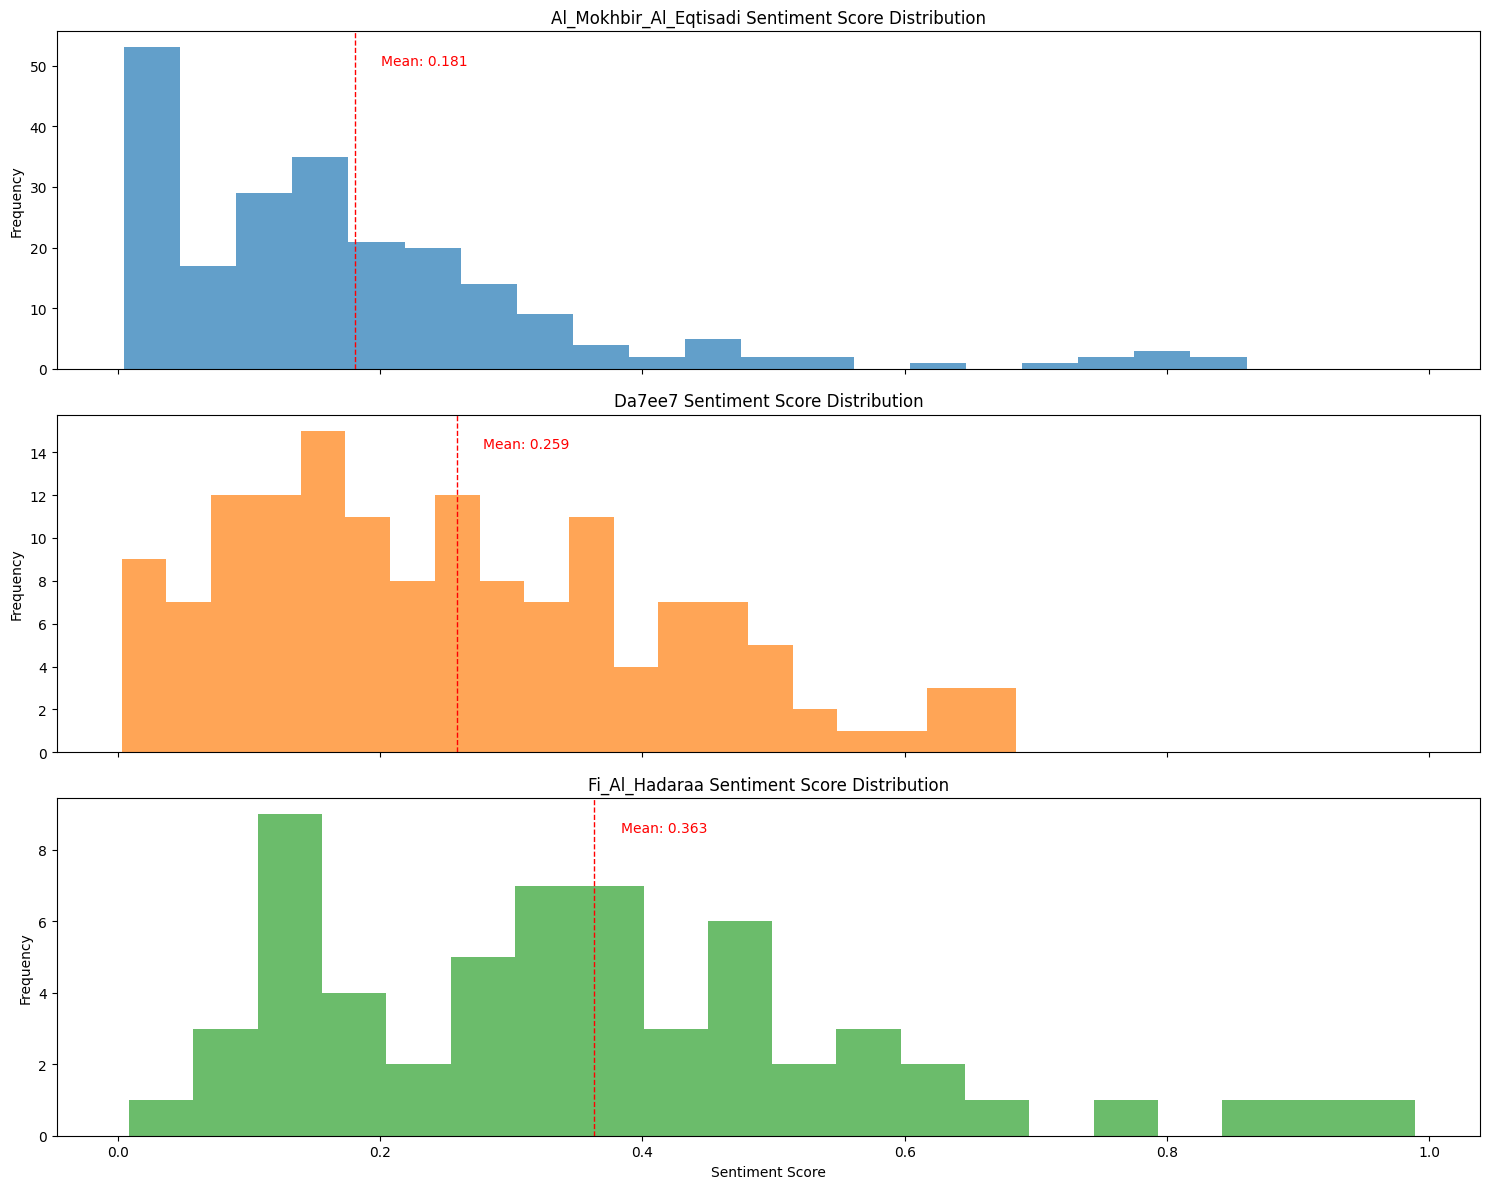

In [14]:
# Draw the sentiment score distribution by creator in 3 subplots sharing the same x-axis
fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
plt.subplots_adjust(hspace=0.3)

for i, creator in enumerate(df['creator'].unique()):
    creator_df = df[df['creator'] == creator]
    axes[i].hist(creator_df['sentiment_score'], bins=20, alpha=0.7, color=f'C{i}')
    axes[i].set_title(f"{creator} Sentiment Score Distribution")
    axes[i].set_ylabel("Frequency")
    
    # Add mean line
    mean_sentiment = creator_df['sentiment_score'].mean()
    axes[i].axvline(mean_sentiment, color='red', linestyle='dashed', linewidth=1)
    axes[i].text(mean_sentiment + 0.02, axes[i].get_ylim()[1]*0.9, f'Mean: {mean_sentiment:.3f}', color='red')

# Set the x-axis label only on the bottom subplot
axes[2].set_xlabel("Sentiment Score")

plt.tight_layout()
plt.show()

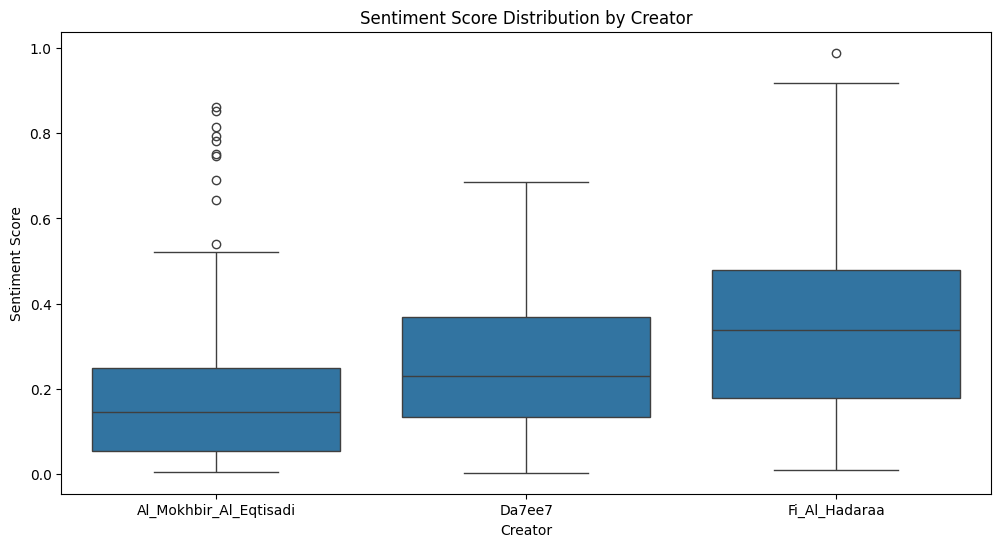

In [16]:
# Draw a boxplot of sentiment scores by creator
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='creator', y='sentiment_score')
plt.title("Sentiment Score Distribution by Creator")
plt.ylabel("Sentiment Score")
plt.xlabel("Creator")
plt.show()

In [17]:
# View number of outliers by creator
def count_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return (series < lower_bound).sum() + (series > upper_bound).sum()

outliers = df.groupby('creator')['sentiment_score'].agg(count_outliers)
outliers

creator
Al_Mokhbir_Al_Eqtisadi    10
Da7ee7                     0
Fi_Al_Hadaraa              1
Name: sentiment_score, dtype: int64

Using the sentiment analysis model the following could be deduced from the above plots:
- `Al Mokhbir Al Eqtisadi` has the lowest sentiment in general compared to the other 2 creators.
- `Al Mokhbir Al Eqtisadi` has a `10` outliers compared to the other creators, which means occassionally he could make episodes talking about positive stuff.
- `Fi Al Hadaraa` has a higher overall sentiment compared to `Al Da7ee7` & `Al Mokhbir Al Eqtisadi`

In [18]:
# Save the cleaned data to a CSV file
df.to_csv("walid_sentiment_cleaned_data.csv", index=False)

### 3. 